In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
from matplotlib import rcParams
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import seaborn as sns
from collections import defaultdict
from sequencing_tools.viz_tools import okabeito_palette, \
                        simpsons_palette, \
                        RNA_base_from_picard, \
                        RNA_cov_from_picard, \
                        color_encoder
from sequencing_tools.stats_tools import normalize_count
from collections import defaultdict
import re
import glob
import os
from plotting_utils import label_sample, rename_sample, \
                        label_ce, rna_type_ce, \
                        figure_path
from count_plot import plot_insert, plot_coding_bases, plot_strand, plot_count, sample_wise_fraction

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# insert size

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


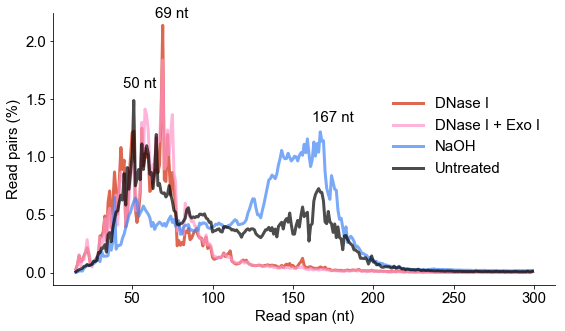

In [2]:
fig = plt.figure(figsize = (9,5))
ax_insert = fig.add_subplot(111)
idf = plot_insert(ax_insert, samples = ['DNase I', 'DNase I + Exo I',
                                       'NaOH', 'Untreated', 'Unfragmented'])#,
                                     # "DNase I - 3'P" ])
sns.despine()
#ax_insert.set_ylim(0,2)
ax_insert.text(64, 2.2, '69 nt', fontsize=15)
ax_insert.text(44, 1.6, '50 nt', fontsize=15)
ax_insert.text(162, 1.3, '167 nt', fontsize=15)

fig.savefig(figure_path + '/insert_plots.pdf', bbox_inches = 'tight')

In [3]:
idf.groupby('label').apply(lambda d: d[d.size_fraction==d.size_fraction.max()])

,,label,isize,size_fraction
label,,,,
DNase I,3751,DNase I,69,2.137538
DNase I + Exo I,623,DNase I + Exo I,69,1.838563
NaOH,152,NaOH,167,1.217203
Untreated,4018,Untreated,51,1.487837


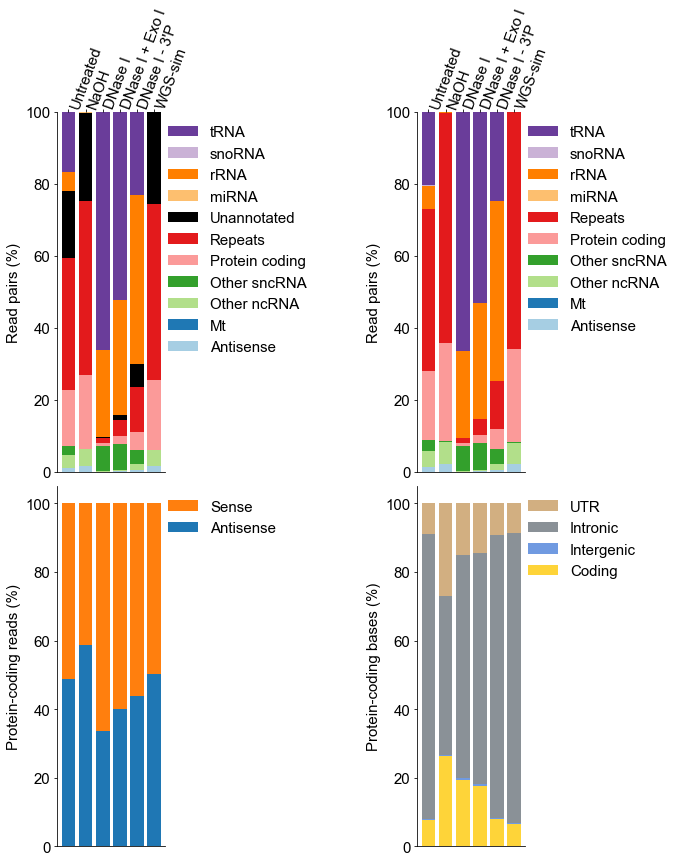

In [4]:
#fig = plt.figure(figsize = (10,8))
#ax_frag_dist = fig.add_axes([0,0,0.15,0.5])
#ax_frag_dist_feature_only = fig.add_axes([0.5,0,0.15,0.5])
#ax_strand = fig.add_axes([1,0,0.15,0.5])
#ax_coding = fig.add_axes([1.4,0,0.15,0.5])

fig = plt.figure(figsize = (10,10))
ax_frag_dist = fig.add_axes([0,0.52,0.15,0.5])
ax_frag_dist_feature_only = fig.add_axes([0.5,0.52,0.15,0.5])
ax_strand = fig.add_axes([0,0,0.15,0.5])
ax_coding = fig.add_axes([0.5,0, 0.15, 0.5])


cdf = plot_count(ax_frag_dist, feature_only=False)
cdf = plot_count(ax_frag_dist_feature_only, feature_only=True)
plot_strand(ax_strand)
plot_coding_bases(ax_coding)
ax_strand.xaxis.set_visible(False)
ax_coding.xaxis.set_visible(False)
ax_frag_dist.xaxis.tick_top()
ax_frag_dist_feature_only.xaxis.tick_top()
#fig.tight_layout()
fig.savefig(figure_path + '/fragment_plots.pdf', bbox_inches = 'tight')

In [5]:
from collections import defaultdict
dedup_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/spreaded_all_counts.feather')
cor_df = np.log(dedup_df\
                .filter(regex = 'Qcf|QCF')\
                .filter(regex="dedup:sense") \
                .pipe(lambda d: d+1))

In [6]:
pd.DataFrame({'a':cor_df.columns, 'b':rename_sample(cor_df.columns)})

,a,b
0,QCF1_R1_001:dedup:sense,DNase I 1
1,QCF2_R1_001:dedup:sense,DNase I 2
2,Qcf10_R1_001:dedup:sense,DNase I 3
3,Qcf11_R1_001:dedup:sense,DNase I 4
4,Qcf12_R1_001:dedup:sense,DNase I 5
5,Qcf13_R1_001:dedup:sense,DNase I 6
6,Qcf4_R1_001:dedup:sense,DNase I 7
7,Qcf5_R1_001:dedup:sense,DNase I 8
8,Qcf6_SS_R1_001:dedup:sense,DNase I 9
9,Qcf7_R1_001:dedup:sense,DNase I 10


Text(0.1,0.86,"Pearson's $\\rho$")

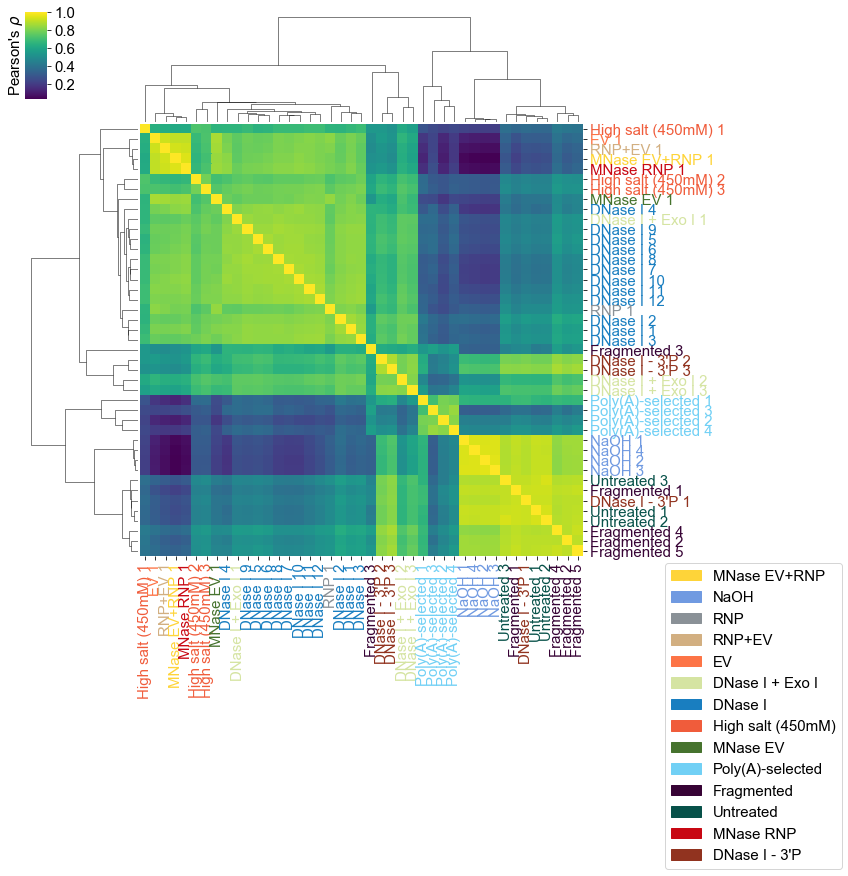

In [7]:
from collections import defaultdict
dedup_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/spreaded_all_counts.feather')
cor_df = np.log(dedup_df\
                .filter(regex = 'Qcf|QCF|PP|MP')\
                .filter(regex="dedup:sense") \
                .pipe(lambda d: d[d.columns[~d.columns.str.contains('LE[0-9]+')]])\
                .pipe(lambda d: d+1))
cor_df.columns = rename_sample(cor_df.columns)
cor_df = cor_df.corr(method='pearson')
p = sns.clustermap(cor_df, cmap = 'viridis')
ax = p.ax_heatmap
xt = ax.set_xticks(range(cor_df.shape[0]))
yt = ax.set_yticks(range(cor_df.shape[1]))
xt = ax.set_xticklabels(cor_df.columns[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[p.dendrogram_row.reordered_ind])

yt = ax.set_yticks(np.arange(cor_df.shape[1])+0.5)
xt = ax.set_xticks(np.arange(cor_df.shape[0])+0.5)

ce = color_encoder()
ce.fit(cor_df.columns.str.replace(' [0-9]+$',''), 
                 simpsons_palette())
for xt in ax.get_xmajorticklabels():
    color = ce.encoder[re.sub(' [0-9]+$','', xt.get_text())]
    xt.set_color(color)
    
for yt in ax.get_ymajorticklabels():
    color = ce.encoder[re.sub(' [0-9]+$','', yt.get_text())]
    yt.set_color(color)

pat = [mpatches.Patch(color=col, label=lab) for lab, col in ce.encoder.items()]
ax.legend(handles=pat, bbox_to_anchor = (1.6,0.), fontsize=15)
p.fig.text(0.1, 0.86, r"Pearson's $\rho$", rotation = 90, fontsize=15)

In [54]:
dedup_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/spreaded_all_counts.feather')


filter_feature = 'No features' 
dedup_regex = ':dedup:' 
norm_df = dedup_df \
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type.str.contains('Y-RNA'), 'Other sncRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type.str.contains("vaultRNA|VT|vt"),'Vault RNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.gene_name.str.contains('^MT-'),'Mt',d.grouped_type))\
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.grouped_type.isin(['rRNA','tRNA','snoRNA','snRNA','Other sncRNA','MT'])])\
        .groupby(['gene_id','gene_name','gene_type','grouped_type'])\
        .sum()\
        .pipe(lambda d: d[d.columns[d.columns.str.contains(dedup_regex)]]) \
        .filter(regex='[Qq][cC][fF][0-9]+|[Pp]hos')\
        .pipe(normalize_count)\
        .reset_index()\
        .pipe(pd.melt, id_vars = ['gene_id','gene_name','gene_type','grouped_type'], 
              var_name = 'samplename', value_name = 'norm_count') 
norm_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/numpy/lib/shape_base.py:357: RuntimeWarning: divide by zero encountered in log
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/numpy/lib/shape_base.py:380: RuntimeWarning: divide by zero encountered in log
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


,gene_id,gene_name,gene_type,grouped_type,samplename,norm_count
0,18S_rRNA,18S_rRNA,18S_rRNA,rRNA,QCF1_R1_001:dedup:sense,64176.255279
1,28S_rRNA,28S_rRNA,28S_rRNA,rRNA,QCF1_R1_001:dedup:sense,142299.811168
2,5.8S_rRNA,5.8S_rRNA,5.8S_rRNA,rRNA,QCF1_R1_001:dedup:sense,40197.038421
3,5S_rRNA,5S_rRNA,5S_rRNA,rRNA,QCF1_R1_001:dedup:sense,44063.796548
4,ENSG00000194270.1,Y_RNA,misc_RNA,Other sncRNA,QCF1_R1_001:dedup:sense,0.000000


In [55]:
rRNA_df = norm_df.query('grouped_type =="rRNA"') \
    .assign(prep = lambda d: d.samplename.map(label_sample)) \
    .reset_index(drop=True) 
rRNA_df.head()

,gene_id,gene_name,gene_type,grouped_type,samplename,norm_count,prep
0,18S_rRNA,18S_rRNA,18S_rRNA,rRNA,QCF1_R1_001:dedup:sense,64176.255279,DNase I
1,28S_rRNA,28S_rRNA,28S_rRNA,rRNA,QCF1_R1_001:dedup:sense,142299.811168,DNase I
2,5.8S_rRNA,5.8S_rRNA,5.8S_rRNA,rRNA,QCF1_R1_001:dedup:sense,40197.038421,DNase I
3,5S_rRNA,5S_rRNA,5S_rRNA,rRNA,QCF1_R1_001:dedup:sense,44063.796548,DNase I
4,18S_rRNA,18S_rRNA,18S_rRNA,rRNA,QCF2_R1_001:dedup:sense,66054.205566,DNase I


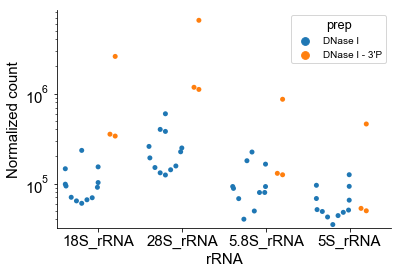

In [56]:
ax = plt.subplot(111)
sns.swarmplot(data = rRNA_df, 
              x = 'gene_name', 
              y = 'norm_count',
              dodge=True,
              hue='prep', ax =ax)
ax.set_yscale('log')
ax.set_ylabel('Normalized count')
ax.set_xlabel('rRNA')
sns.despine()

In [63]:
norm_df = dedup_df \
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type.str.contains('Y-RNA'), 'Other sncRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type.str.contains("vaultRNA|VT|vt"),'Vault RNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.gene_name.str.contains('^MT-'),'Mt',d.grouped_type))\
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[~d.grouped_type.isin(['Repeats','No features'])])\
        .groupby(['gene_id','gene_name','gene_type','grouped_type'])\
        .sum()\
        .pipe(lambda d: d[d.columns[d.columns.str.contains(dedup_regex)]]) \
        .filter(regex='[Qq][cC][fF][0-9]+|[Pp]hos|^[MP]P')\
        .pipe(normalize_count)\
        .reset_index()\
        .pipe(pd.melt, id_vars = ['gene_id','gene_name','gene_type','grouped_type'], 
              var_name = 'samplename', value_name = 'norm_count') \
        .assign(prep = lambda d: d.samplename.map(label_sample)) 
norm_df.head()

,gene_id,gene_name,gene_type,grouped_type,samplename,norm_count,prep
0,18S_rRNA,18S_rRNA,18S_rRNA,rRNA,MPCEV_R1_001:dedup:sense,8728.586814,RNP+EV
1,28S_rRNA,28S_rRNA,28S_rRNA,rRNA,MPCEV_R1_001:dedup:sense,13479.719191,RNP+EV
2,5.8S_rRNA,5.8S_rRNA,5.8S_rRNA,rRNA,MPCEV_R1_001:dedup:sense,11368.294150,RNP+EV
3,5S_rRNA,5S_rRNA,5S_rRNA,rRNA,MPCEV_R1_001:dedup:sense,6320.642033,RNP+EV
4,ENSG00000000003.14_2,TSPAN6,protein_coding,Protein coding,MPCEV_R1_001:dedup:sense,0.000000,RNP+EV


In [66]:
norm_df\
    .query('grouped_type == "Mt" & gene_type == "Mt_tRNA"')\
    .pipe(pd.pivot_table, index=['gene_id','gene_name','gene_type'],
         columns = 'samplename', values = 'norm_count')

,,samplename,MPCEV_R1_001:dedup:sense,MPF10_R1_001:dedup:sense,MPF4_R1_001:dedup:sense,PPCEV_R1_001:dedup:sense,PPF10_R1_001:dedup:sense,PPF4_R1_001:dedup:sense,QCF1_R1_001:dedup:sense,QCF2_R1_001:dedup:sense,Qcf10_R1_001:dedup:sense,Qcf11_R1_001:dedup:sense,...,Qcf13_R1_001:dedup:sense,Qcf4_R1_001:dedup:sense,Qcf5_R1_001:dedup:sense,Qcf6_SS_R1_001:dedup:sense,Qcf7_R1_001:dedup:sense,Qcf8_R1_001:dedup:sense,Qcf9_R1_001:dedup:sense,Qcf_Phos1_R1_001:dedup:sense,Qcf_Phos2_R1_001:dedup:sense,Qcf_Phos3_R1_001:dedup:sense
gene_id,gene_name,gene_type,,,,,,,,,,,,,,,,,,,,,
ENSG00000210100.1,MT-TI,Mt_tRNA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
ENSG00000210107.1,MT-TQ,Mt_tRNA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
ENSG00000210112.1,MT-TM,Mt_tRNA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
ENSG00000210117.1,MT-TW,Mt_tRNA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,4.244023,0.0,0.0
ENSG00000210127.1,MT-TA,Mt_tRNA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,1.285394,0.0,0.000000,0.0,0.0
ENSG00000210135.1,MT-TN,Mt_tRNA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,1.285394,0.0,0.000000,0.0,0.0
ENSG00000210140.1,MT-TC,Mt_tRNA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.048728,1.301319,0.0,0.0,1.285394,0.0,0.000000,0.0,0.0
ENSG00000210144.1,MT-TY,Mt_tRNA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.048728,1.301319,0.0,0.0,1.285394,0.0,0.000000,0.0,0.0
ENSG00000210151.2,MT-TS1,Mt_tRNA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.048728,1.301319,0.0,0.0,1.285394,0.0,0.000000,0.0,0.0
